# Setup

In [1]:
import os
import shutil
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import sampler

to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


# 定义网络模型

In [23]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            #32*16*16
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            #64*8*8
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            
            #128*4*4
            nn.Flatten(),
            nn.Linear(128*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)
# model = Net()
# print(model)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #32*16*16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #64*8*8
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #128*4*4
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)

# 打印准确率函数

In [3]:
def check_accuracy_part34(loader, model):
  #if loader.dataset.train:
  #  print('Checking accuracy on validation set')
  #else:
  #  print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

# 加载数据集

In [42]:
train_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/train')
test_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/test')

# 随机提取6类训练5次，最终结果取平均

In [24]:
main_dir = os.getcwd()
train_dir = main_dir + "/extract_train"
test_dir = main_dir + "/extract_test"

epochs = 20
total = []

for i in range(5):
    #建立存放数据集的文件夹
    if os.path.exists(train_dir) and os.path.exists(test_dir):
        shutil.rmtree(train_dir)
        shutil.rmtree(test_dir)
        os.mkdir(train_dir)
        os.mkdir(test_dir)
    else:
        os.mkdir(train_dir)
        os.mkdir(test_dir)
        
    #生成6个随机数，用于提取数据集中的6类
    class_6 = torch.randperm(10)[:6]
    print("Extract classes: ", class_6, "\n")

    #提取6类并保存至新的文件夹
    for i in range(50000):
        train_label = train_data.imgs[i][1]

        if train_label in class_6:
            train_label_dir = train_dir + "/" + str(train_label)
            if os.path.exists(train_label_dir):
                pass
            else:
                os.mkdir(train_label_dir)
            image_path = train_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = train_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)

    for i in range(10000):
        test_label = test_data.imgs[i][1]

        if test_label in class_6:
            test_label_dir = test_dir + "/" + str(test_label)
            if os.path.exists(test_label_dir):
                pass
            else:
                os.mkdir(test_label_dir)
            image_path = test_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = test_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)
            
    #定义预处理操作
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    #数据集预处理
    train_data_ = datasets.ImageFolder(train_dir, transform=transform)
    test_data_ = datasets.ImageFolder(test_dir, transform=transform)

    #数据集采样、打包
    n_train = len(train_data_)  #30000

    split = 21000
    indices = list(range(n_train))
    random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data_, batch_size=60, 
                                              sampler=sampler.SubsetRandomSampler(indices[:split]))
    valid_loader = torch.utils.data.DataLoader(train_data_, batch_size=60, 
                                            sampler=sampler.SubsetRandomSampler(indices[split:]))
    test_loader = torch.utils.data.DataLoader(test_data_, batch_size=60, shuffle=True)
    
    #定义网络与参数更新方法
    model = Net()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    #训练网络
#     num_prints = epochs * len(train_loader) // 100 + 1  #如果batchsize为64，则需+1
#     acc_history = torch.zeros(num_prints, dtype=to_float)
#     iter_history = torch.zeros(num_prints, dtype=to_long)
    acc_history = []
    iter_history = []
    model = model.to(device=device)# move the model parameters to CPU/GPU
    for epoch in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            # Move the data to the proper device (GPU or CPU)
            x = x.to(device=device, dtype=to_float)
            y = y.to(device=device, dtype=to_long)

            # Forward pass: compute scores and loss
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            #Backwards pass: compute the gradient
            loss.backward()

            #Update the parameters
            optimizer.step()

            tt = t + epoch * len(train_loader)

            if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
                print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
                acc = check_accuracy_part34(valid_loader, model)
#                 acc_history[tt // 100] = acc
#                 iter_history[tt // 100] = tt
                acc_history.append(acc)
                iter_history.append(tt)
                print()
    test_acc = check_accuracy_part34(test_loader, model) * 100
    print()
    total.append(test_acc)
    
print("Accuracies on test set: ", total)
final_acc = sum(total) / len(total)
print("Final accuracy: %.2f" %final_acc)

Extract classes:  tensor([9, 1, 2, 7, 4, 5]) 

Epoch: 0, Iteration: 0, loss = 1.8256
Got 1769 / 9000 correct (19.66)

Epoch: 0, Iteration: 100, loss = 1.3026
Got 4342 / 9000 correct (48.24)

Epoch: 0, Iteration: 200, loss = 1.2474
Got 5050 / 9000 correct (56.11)

Epoch: 0, Iteration: 300, loss = 0.9574
Got 5344 / 9000 correct (59.38)

Epoch: 1, Iteration: 400, loss = 0.9636
Got 5367 / 9000 correct (59.63)

Epoch: 1, Iteration: 500, loss = 1.3340
Got 5584 / 9000 correct (62.04)

Epoch: 1, Iteration: 600, loss = 0.8562
Got 5786 / 9000 correct (64.29)

Epoch: 2, Iteration: 700, loss = 0.6171
Got 6270 / 9000 correct (69.67)

Epoch: 2, Iteration: 800, loss = 0.6698
Got 6446 / 9000 correct (71.62)

Epoch: 2, Iteration: 900, loss = 0.6694
Got 6691 / 9000 correct (74.34)

Epoch: 2, Iteration: 1000, loss = 0.4873
Got 6456 / 9000 correct (71.73)

Epoch: 3, Iteration: 1100, loss = 0.6526
Got 6644 / 9000 correct (73.82)

Epoch: 3, Iteration: 1200, loss = 0.6740
Got 6384 / 9000 correct (70.93)

Epo

Epoch: 10, Iteration: 3800, loss = 0.1446
Got 7799 / 9000 correct (86.66)

Epoch: 11, Iteration: 3900, loss = 0.0753
Got 7800 / 9000 correct (86.67)

Epoch: 11, Iteration: 4000, loss = 0.1086
Got 7884 / 9000 correct (87.60)

Epoch: 11, Iteration: 4100, loss = 0.1572
Got 7753 / 9000 correct (86.14)

Epoch: 12, Iteration: 4200, loss = 0.0806
Got 7905 / 9000 correct (87.83)

Epoch: 12, Iteration: 4300, loss = 0.1223
Got 7789 / 9000 correct (86.54)

Epoch: 12, Iteration: 4400, loss = 0.0273
Got 7877 / 9000 correct (87.52)

Epoch: 12, Iteration: 4500, loss = 0.0259
Got 7812 / 9000 correct (86.80)

Epoch: 13, Iteration: 4600, loss = 0.0260
Got 7949 / 9000 correct (88.32)

Epoch: 13, Iteration: 4700, loss = 0.0488
Got 7879 / 9000 correct (87.54)

Epoch: 13, Iteration: 4800, loss = 0.0396
Got 7892 / 9000 correct (87.69)

Epoch: 14, Iteration: 4900, loss = 0.0285
Got 7936 / 9000 correct (88.18)

Epoch: 14, Iteration: 5000, loss = 0.0282
Got 7971 / 9000 correct (88.57)

Epoch: 14, Iteration: 510

Epoch: 1, Iteration: 400, loss = 0.6655
Got 6190 / 9000 correct (68.78)

Epoch: 1, Iteration: 500, loss = 0.8249
Got 6351 / 9000 correct (70.57)

Epoch: 1, Iteration: 600, loss = 0.8860
Got 5821 / 9000 correct (64.68)

Epoch: 2, Iteration: 700, loss = 0.6490
Got 6774 / 9000 correct (75.27)

Epoch: 2, Iteration: 800, loss = 0.7357
Got 6786 / 9000 correct (75.40)

Epoch: 2, Iteration: 900, loss = 0.5055
Got 6755 / 9000 correct (75.06)

Epoch: 2, Iteration: 1000, loss = 0.6790
Got 6863 / 9000 correct (76.26)

Epoch: 3, Iteration: 1100, loss = 0.5911
Got 7060 / 9000 correct (78.44)

Epoch: 3, Iteration: 1200, loss = 0.5851
Got 6843 / 9000 correct (76.03)

Epoch: 3, Iteration: 1300, loss = 0.5925
Got 6196 / 9000 correct (68.84)

Epoch: 4, Iteration: 1400, loss = 0.4214
Got 7185 / 9000 correct (79.83)

Epoch: 4, Iteration: 1500, loss = 0.3939
Got 7341 / 9000 correct (81.57)

Epoch: 4, Iteration: 1600, loss = 0.3946
Got 7268 / 9000 correct (80.76)

Epoch: 4, Iteration: 1700, loss = 0.6162
Got

Got 6877 / 9000 correct (76.41)

Epoch: 12, Iteration: 4300, loss = 0.1541
Got 6806 / 9000 correct (75.62)

Epoch: 12, Iteration: 4400, loss = 0.1562
Got 6848 / 9000 correct (76.09)

Epoch: 12, Iteration: 4500, loss = 0.1642
Got 6822 / 9000 correct (75.80)

Epoch: 13, Iteration: 4600, loss = 0.0809
Got 6981 / 9000 correct (77.57)

Epoch: 13, Iteration: 4700, loss = 0.1611
Got 6510 / 9000 correct (72.33)

Epoch: 13, Iteration: 4800, loss = 0.1105
Got 6912 / 9000 correct (76.80)

Epoch: 14, Iteration: 4900, loss = 0.1255
Got 6702 / 9000 correct (74.47)

Epoch: 14, Iteration: 5000, loss = 0.1265
Got 6692 / 9000 correct (74.36)

Epoch: 14, Iteration: 5100, loss = 0.0489
Got 6905 / 9000 correct (76.72)

Epoch: 14, Iteration: 5200, loss = 0.1143
Got 6795 / 9000 correct (75.50)

Epoch: 15, Iteration: 5300, loss = 0.0366
Got 6939 / 9000 correct (77.10)

Epoch: 15, Iteration: 5400, loss = 0.0398
Got 6952 / 9000 correct (77.24)

Epoch: 15, Iteration: 5500, loss = 0.1069
Got 6852 / 9000 correct (

# 随机提取6类进行单次训练

## 提取数据集

In [4]:
train_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/train')
test_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/test')

In [5]:
main_dir = os.getcwd()
train_dir = main_dir + "/extract_train"
test_dir = main_dir + "/extract_test"

for i in range(1):
    #建立存放数据集的文件夹
    if os.path.exists(train_dir) and os.path.exists(test_dir):
        shutil.rmtree(train_dir)
        shutil.rmtree(test_dir)
        os.mkdir(train_dir)
        os.mkdir(test_dir)
    else:
        os.mkdir(train_dir)
        os.mkdir(test_dir)
        
    #生成6个随机数，用于提取数据集中的6类
#     class_6 = torch.randperm(10)[:6]
    class_6 = torch.tensor([0, 5, 8, 4, 7, 3])
    print("Extract classes: ", class_6, "\n")

    #提取6类并保存至新的文件夹
    for i in range(50000):
        train_label = train_data.imgs[i][1]

        if train_label in class_6:
            train_label_dir = train_dir + "/" + str(train_label)
            if os.path.exists(train_label_dir):
                pass
            else:
                os.mkdir(train_label_dir)
            image_path = train_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = train_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)

    for i in range(10000):
        test_label = test_data.imgs[i][1]

        if test_label in class_6:
            test_label_dir = test_dir + "/" + str(test_label)
            if os.path.exists(test_label_dir):
                pass
            else:
                os.mkdir(test_label_dir)
            image_path = test_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = test_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)

Extract classes:  tensor([0, 5, 8, 4, 7, 3]) 



## 数据集加载

In [20]:
#定义预处理操作
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

#数据集预处理
train_data_ = datasets.ImageFolder(train_dir, transform=transform)
test_data_ = datasets.ImageFolder(test_dir, transform=transform)

#数据集采样、打包
n_train = len(train_data_)  #30000

split = 21000
indices = list(range(n_train))
random.shuffle(indices)

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                          sampler=sampler.SubsetRandomSampler(indices[:split]))
valid_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                        sampler=sampler.SubsetRandomSampler(indices[split:]))
test_loader = torch.utils.data.DataLoader(test_data_, batch_size=64, shuffle=True)

## 训练网络

In [10]:
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [18]:
#定义网络与参数更新方法
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.1)
#增
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 20
#num_prints = epochs * len(train_loader) // 100
# acc_history = torch.zeros(num_prints, dtype=to_float)
# iter_history = torch.zeros(num_prints, dtype=to_long)
acc_history = []
iter_history = []
model = model.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long)
        
        # Forward pass: compute scores and loss
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model)
            acc_history.append(round(acc, 4))
            iter_history.append(tt)
            print()
    #增
#     scheduler.step()
    
check_accuracy_part34(test_loader, model)

Epoch: 0, Iteration: 0, loss = 1.7646
Got 1471 / 9000 correct (16.34)

Epoch: 0, Iteration: 100, loss = 1.1413
Got 4881 / 9000 correct (54.23)

Epoch: 0, Iteration: 200, loss = 1.0098
Got 5256 / 9000 correct (58.40)

Epoch: 0, Iteration: 300, loss = 1.0251
Got 5263 / 9000 correct (58.48)

Epoch: 1, Iteration: 400, loss = 0.8412
Got 5627 / 9000 correct (62.52)

Epoch: 1, Iteration: 500, loss = 0.8824
Got 5735 / 9000 correct (63.72)

Epoch: 1, Iteration: 600, loss = 0.7667
Got 5831 / 9000 correct (64.79)

Epoch: 2, Iteration: 700, loss = 0.7532
Got 5592 / 9000 correct (62.13)

Epoch: 2, Iteration: 800, loss = 1.1224
Got 5876 / 9000 correct (65.29)

Epoch: 2, Iteration: 900, loss = 0.7537
Got 5887 / 9000 correct (65.41)

Epoch: 2, Iteration: 1000, loss = 0.7612
Got 6162 / 9000 correct (68.47)

Epoch: 3, Iteration: 1100, loss = 0.7019
Got 6407 / 9000 correct (71.19)

Epoch: 3, Iteration: 1200, loss = 0.8598
Got 6305 / 9000 correct (70.06)

Epoch: 3, Iteration: 1300, loss = 0.6565
Got 6393 

0.7985

In [21]:
#定义网络与参数更新方法
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
#增
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 20
#num_prints = epochs * len(train_loader) // 100
# acc_history = torch.zeros(num_prints, dtype=to_float)
# iter_history = torch.zeros(num_prints, dtype=to_long)
acc_history = []
iter_history = []
model = model.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long)
        
        # Forward pass: compute scores and loss
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model)
            acc_history.append(round(acc, 4))
            iter_history.append(tt)
            print()
    #增
#     scheduler.step()
    
check_accuracy_part34(test_loader, model)

Epoch: 0, Iteration: 0, loss = 1.7910
Got 1768 / 9000 correct (19.64)

Epoch: 0, Iteration: 100, loss = 1.4763
Got 4298 / 9000 correct (47.76)

Epoch: 0, Iteration: 200, loss = 1.0179
Got 4631 / 9000 correct (51.46)

Epoch: 0, Iteration: 300, loss = 1.0910
Got 5186 / 9000 correct (57.62)

Epoch: 1, Iteration: 400, loss = 0.8806
Got 5378 / 9000 correct (59.76)

Epoch: 1, Iteration: 500, loss = 1.0339
Got 5565 / 9000 correct (61.83)

Epoch: 1, Iteration: 600, loss = 0.9987
Got 5708 / 9000 correct (63.42)

Epoch: 2, Iteration: 700, loss = 0.8058
Got 5609 / 9000 correct (62.32)

Epoch: 2, Iteration: 800, loss = 0.9608
Got 5699 / 9000 correct (63.32)

Epoch: 2, Iteration: 900, loss = 0.7378
Got 5836 / 9000 correct (64.84)

Epoch: 3, Iteration: 1000, loss = 0.8309
Got 5837 / 9000 correct (64.86)

Epoch: 3, Iteration: 1100, loss = 0.7693
Got 5930 / 9000 correct (65.89)

Epoch: 3, Iteration: 1200, loss = 0.7589
Got 6098 / 9000 correct (67.76)

Epoch: 3, Iteration: 1300, loss = 0.8704
Got 6087 

0.5855

In [16]:
print(iter_history)
print(acc_history)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 6999]
[0.2157, 0.4636, 0.5399, 0.6134, 0.5973, 0.6502, 0.6121, 0.6216, 0.6987, 0.6471, 0.6934, 0.6688, 0.6887, 0.7097, 0.7398, 0.7258, 0.686, 0.6929, 0.7203, 0.7344, 0.7514, 0.7533, 0.7551, 0.7523, 0.7543, 0.7613, 0.7672, 0.752, 0.7667, 0.776, 0.7641, 0.7424, 0.7658, 0.7579, 0.7381, 0.7692, 0.7774, 0.7691, 0.7819, 0.777, 0.7761, 0.7817, 0.7762, 0.7892, 0.7794, 0.7719, 0.7919, 0.7661, 0.7882, 0.7811, 0.795, 0.7883, 0.7847, 0.7891, 0.7911, 0.7912, 0.7888, 0.7954, 0.7953, 0.7946, 0.8032, 0.7974, 0.7986, 0.7982, 0.8041, 0.8024, 0.804, 0.8034, 0.8042, 0.8024, 0.8026]


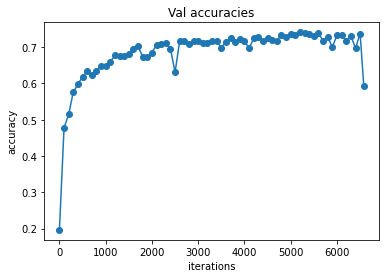

In [22]:
#6 9.8
#SGD lr=0.01 epoch=20 batch_size=64
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

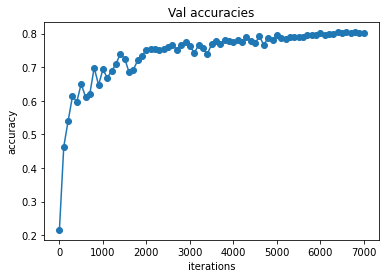

In [15]:
#6 9.8
#SGD lr=0.1 epoch=20 batch_size=60 Conv滤波器数目32-64-128，MaxPool改为AvgPool
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

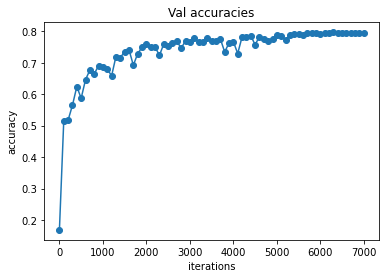

In [11]:
#5 9.8
#SGD lr=0.1 epoch=20 batch_size=60 Conv滤波器数目32-64-128
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

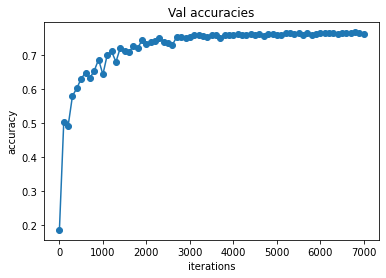

In [12]:
#4 9.7
#SGD lr=0.1 epoch=20 batch_size=60 使用optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

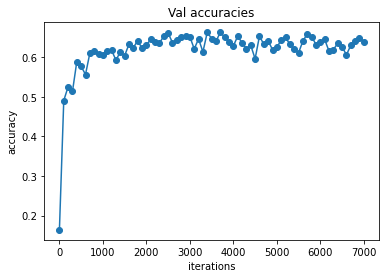

In [8]:
#3 9.7
#SGD lr=0.1 epoch=20 batch_size=60 momentum=0.9 加了momentum反而不如原来高
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

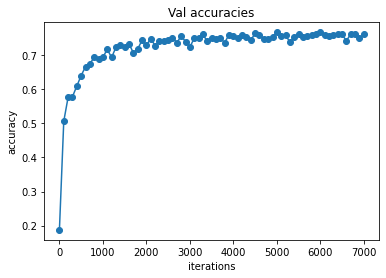

In [14]:
#2 9.6
#SGD lr=0.1 epoch=20 batch_size=60
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

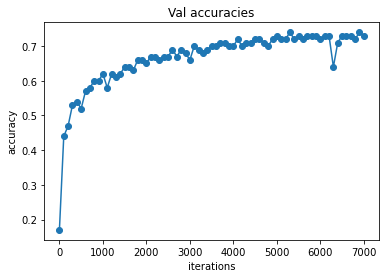

In [11]:
#1 9.5
#SGD lr=0.01 epoch=20 batch_size=60
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()